In [69]:
# --- Baseline packages ---
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# --- Deep learning packages ---
from torch.utils.data import DataLoader
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# --- Statistical packages ---
from sklearn import metrics

# --- Visualisation packages ---
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
import seaborn as sns
import altair as alt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Utility packages ---
import os
import sys
import joblib
import json

# --- Helper functions ---
sys.path.append(os.path.abspath('../src'))
import ecg_utils
from ecg_utils.ecg_dataloader import CustomLMDBDataset

# **4.0.** Preliminaries

In [70]:
# Get runtime.
device = ecg_utils.check_runtime_device()

# Set global seeds.
ecg_utils.set_global_seeds(seed_num=42)

# Label encoder.
rhythm_encoder_path = os.path.join("..", "..", "data", "metadata", "rhythm_encoders_dict.joblib")
rhythm_encoders = joblib.load(rhythm_encoder_path)
l1_rhythm_encoder = rhythm_encoders['rhythm_l1_enc']

# Identify relevant folder.
main_data_dir = os.path.join("..", "..", 'data')
project_dir = os.path.join("..")
final_results_dir = os.path.join("..", "final-results")

# Get consolidated final results.
output_filepath = os.path.join("..", "final-results", "analysis_df.csv")
analysis_df = pd.read_csv(output_filepath)

# Add column for chart labelling purposes.
model_arch_list = ['mobilenetv3small', 'mobilenetv3large', 'resnet18', 'resnet50', 'efficientnetb0', 'efficientnetb3', 'convnexttiny', 'convnextbase']
model_arch_name = ['MobileNetV3-small', 'MobileNetV3-large', 'ResNet-18', 'ResNet-50', 'EfficientNet-B0', 'EfficientNet-B3', 'ConvNeXt-tiny', 'ConvNeXt-base']
arch_name_dict = {arch:name for arch, name in zip(model_arch_list, model_arch_name)}
analysis_df['model_arch_label'] = analysis_df['model_arch'].apply(lambda x: arch_name_dict[x])

Runtime type: mps
Global seed for torch set.
Global seed for numpy and python's inbuilt RNG set.


# **4.1.** Main Results

### **4.1.1.** Overall Evaluation Metrics Comparison

##### **4.1.1.a.** Performance on Hold-out Test Set by Training Stages

In [71]:
# Define a function to evaluate models from torchvision model zoo.
def evaluate_base_models(
        model_arch,
        device,
        label_enc,
        dataset_config = "config1_adj",
        dataset_type = "test",
        metric_name = 'f1'
):  
    lmdb_path, csv_path = ecg_utils.get_dataset_paths(main_data_dir, model_arch, dataset_config, dataset_type)
    lmdb_dataset = CustomLMDBDataset(lmdb_path, csv_path)

    cnn_model = ecg_utils.get_cnn_model(model_arch, lmdb_dataset.get_num_classes(), freezeBackbone=True)
    cnn_model = cnn_model.to(device).eval()
    _, metric_scores_dict = ecg_utils.evaluate_model_predictions(
        lmdb_path,
        csv_path,
        cnn_model,
        label_enc,
        device=device
    )

    return metric_scores_dict[metric_name]


# Define a function to evaluate intermediate models - models that only its classification head was trained.
def evaluate_tf_models(
        model_arch,
        device,
        label_enc,
        dataset_config = "config1_adj",
        dataset_type = "test",
        metric_name = 'f1'
):
    lmdb_path, csv_path = ecg_utils.get_dataset_paths(main_data_dir, model_arch, dataset_config, dataset_type)
    lmdb_dataset = CustomLMDBDataset(lmdb_path, csv_path)

    config_file = os.path.join("..", "final-results", f'{model_arch}_{dataset_config}', 'best_model_config.json')
    with open(config_file, 'r') as file:
        config_contents = json.load(file)
    
    state_dict_path = os.path.join("..", "experiments", config_contents['state_dict_folder'], "final-models", "best", "best_model.pth")

    cnn_model = ecg_utils.get_cnn_model(model_arch, lmdb_dataset.get_num_classes(), freezeBackbone=False, stateDictPath=state_dict_path)
    cnn_model = cnn_model.to(device).eval()
    _, metric_scores_dict = ecg_utils.evaluate_model_predictions(
        lmdb_path,
        csv_path,
        cnn_model,
        label_enc,
        device=device
    )

    return metric_scores_dict[metric_name]

In [72]:
%%capture

# Get results of unoptimised models (torchvision model zoo) and intermediate models (head-only trained models),
base_results = {}
tf_results = {}
model_arch_list = ['mobilenetv3small', 'mobilenetv3large', 'resnet18', 'resnet50', 'efficientnetb0', 'efficientnetb3', 'convnexttiny', 'convnextbase']
for arch in model_arch_list:
    base_scores_dict = evaluate_base_models(arch, device, l1_rhythm_encoder)
    base_results[arch] = base_scores_dict

    tf_scores_dict = evaluate_tf_models(arch, device, l1_rhythm_encoder)
    tf_results[arch] = tf_scores_dict

# Process base results.
base_df = pd.DataFrame(base_results).reset_index().melt(
    id_vars = 'index',
    var_name = 'model_arch',
    value_name = 'f1_score'
).rename(
    columns={"index": "label_name"}
).reset_index(drop=True)

# Process intermediate results.
tf_df = pd.DataFrame(tf_results).reset_index().melt(
    id_vars = 'index',
    var_name = 'model_arch',
    value_name = 'f1_score'
).rename(
    columns={"index": "label_name"}
).reset_index(drop=True)


# Combine base, intermediate, and final results into one DataFrame.
base_df_overall = base_df.query("label_name == 'macro_avg'").copy()
base_df_overall['model_type'] = 'Off-the-shelf Model'

tf_df_overall = tf_df.query("label_name == 'macro_avg'").copy()
tf_df_overall['model_type'] = 'Head-only Trained Model'

optimised_df_overall = analysis_df.query(
    "dataset_config == 'config1' and dataset_type == 'test' and metric_name == 'f1' and label_name == 'macro_avg'"
).rename(
    columns={"results": "f1_score"}
).loc[:, ['label_name', 'model_arch', 'f1_score']].copy()
optimised_df_overall['model_type'] = 'Fully Optimised Model'

overall_df = pd.concat([base_df_overall, tf_df_overall, optimised_df_overall], ignore_index=True)

In [73]:
model_arch_list = ['mobilenetv3small', 'mobilenetv3large', 'resnet18', 'resnet50', 'efficientnetb0', 'efficientnetb3', 'convnexttiny', 'convnextbase']
model_arch_name = ['MobileNetV3-small', 'MobileNetV3-large', 'ResNet-18', 'ResNet-50', 'EfficientNet-B0', 'EfficientNet-B3', 'ConvNeXt-tiny', 'ConvNeXt-base']
arch_name_dict = {arch:name for arch, name in zip(model_arch_list, model_arch_name)}

overall_df['model_arch_label'] = overall_df['model_arch'].apply(lambda x: arch_name_dict[x])

In [74]:
final_f1_sort = overall_df[overall_df['model_type'] == 'Fully Optimised Model'].sort_values('f1_score', ascending=True).model_arch.tolist()

point_chart = alt.Chart(overall_df).mark_point(
    filled = True,
    size = 200
).encode(
    x = alt.X('model_arch_label', sort=final_f1_sort, title="CNN Architecture", axis=alt.Axis(grid=False)),
    y = alt.Y('f1_score', title='F1 Score', axis=alt.Axis(grid=False)),
    color = alt.Color("model_type", title="Model Version", scale=alt.Scale(domain=['Off-the-shelf Model', 'Head-only Trained Model', 'Fully Optimised Model'], range=["#DCCECE", "#A7A0A0", "#0C0B0B"]), legend=alt.Legend(orient='bottom', direction='horizontal'))
)

line_chart = alt.Chart(overall_df).mark_line(
    color="lightgray"
).encode(
    x=alt.X("model_arch_label", sort=final_f1_sort, axis=alt.Axis(grid=False)),
    y=alt.Y('f1_score', axis=alt.Axis(grid=False)),
    detail="model_arch",
    strokeDash=alt.value([4, 2]),
    strokeWidth=alt.value(1)
)

alt.layer(line_chart, point_chart).properties(
    width = 410,
    height = 250
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    padding=5
)

alt.LayerChart(...)

##### **4.1.1.b.** Overall Evaluation Metrics by Model

In [75]:
arch_sort = [('mobilenetv3', 'mobilenetv3small'), ('mobilenetv3', 'mobilenetv3large'), ('resnet', 'resnet18'), ('resnet', 'resnet50'),
            ('efficientnet', 'efficientnetb0'), ('efficientnet', 'efficientnetb3'), ('convnext', 'convnexttiny'), ('convnext', 'convnextbase')]
metrics_sort = ['f1', 'recall', 'precision', 'accuracy', 'auroc']

overall_metrics_df = analysis_df.query(
    "dataset_config == 'config1' and dataset_type == 'test' and label_name == 'macro_avg'"
).copy()
overall_metrics_df = overall_metrics_df.loc[:, ['arch_family', 'arch_variant', 'model_arch', 'metric_name', 'results']].copy()

overall_metrics_df.pivot(
    index = 'metric_name',
    columns = ['arch_family', 'model_arch'],
    values = 'results'
).drop(
    ['n_samples', 'throughput', 'total_inference_time'], axis=0
).reindex(metrics_sort, columns=arch_sort).round(4)

arch_family      mobilenetv3                    resnet           \
model_arch  mobilenetv3small mobilenetv3large resnet18 resnet50   
metric_name                                                       
f1                    0.9296           0.9380   0.9533   0.9486   
recall                0.9292           0.9366   0.9528   0.9474   
precision             0.9321           0.9397   0.9539   0.9512   
accuracy              0.9381           0.9448   0.9580   0.9537   
auroc                 0.9921           0.9905   0.9932   0.9942   

arch_family   efficientnet                    convnext               
model_arch  efficientnetb0 efficientnetb3 convnexttiny convnextbase  
metric_name                                                          
f1                  0.9541         0.9575       0.9486       0.9612  
recall              0.9534         0.9570       0.9484       0.9603  
precision           0.9550         0.9580       0.9493       0.9621  
accuracy            0.9589         0.9618       0.9537       0.9655  
auroc               0.9925         0.9947       0.9927       0.9950

### **4.1.2.** Model Generalisability

##### **4.1.2.a.** Performance on Train vs Hold-out Test Set: Overall

In [76]:
# Define function to compare scores and sort according to performance on test set.
def compare_train_test_scores(
        df,
        label_name,
        x_axis = 'model_arch_label',
        y_axis = 'results',
        y_axis_range = [0.8, 1.0],
        metric_name = 'f1',
        dataset_config = 'config1',
        chart_title = 'F1 Scores by CNN Architectures',
        chart_width = 410,
        chart_height = 250
):
    sort_cond = (df['label_name']==label_name)& (df['metric_name']==metric_name) & (df['dataset_config']==dataset_config) & (df['dataset_type']=='test')
    sort_label = df[sort_cond].sort_values(y_axis, ascending=True).model_arch_label.tolist()

    base_chart = alt.Chart(df).encode(
        x = alt.X(f'{x_axis}:N', title="CNN Architecture", sort=sort_label),
        y = alt.Y(f'{y_axis}:Q', title="F1 Score", scale=alt.Scale(domain=y_axis_range)).stack(None)
    ).transform_filter(
        alt.datum.metric_name == metric_name,
        alt.datum.dataset_config == dataset_config,
        alt.datum.label_name == label_name
    )

    train_chart = base_chart.transform_filter(
        alt.datum.dataset_type == 'train',
    ).mark_bar(opacity=0.65)

    test_chart = base_chart.transform_filter(
        alt.datum.dataset_type == 'test',
    ).mark_bar(opacity=0.65)

    final_chart = alt.layer(train_chart, test_chart).encode(
        color=alt.Color('dataset_type:N', title='Dataset Type', scale=alt.Scale(domain=['train', 'test'], range=["#C6BCBC", '#525252']), legend=alt.Legend(orient='bottom', direction='horizontal', labelExpr="datum.label == 'train' ? 'Training Set' : 'Test Set'"))
    ).properties(
        title = chart_title,
        width = chart_width,
        height = chart_height,
    )

    return final_chart

In [77]:
overall_chart = compare_train_test_scores(
    analysis_df,
    'macro_avg',
    y_axis_range = [0., 1.0],
    chart_title='',
    chart_width=410,
    chart_height=250
)

overall_chart.configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    padding=5
)

alt.LayerChart(...)

##### **4.1.2.b.** Performance on Train vs Hold-out Test Set: By Class

In [78]:
label_list = ['AFIB', 'GSVT', 'SR', 'SB']
chart_list = [compare_train_test_scores(
    analysis_df,
    lab,
    y_axis_range = [0., 1.0],
    chart_title=f'{lab}',
    chart_width=410,
    chart_height=250
) for lab in label_list]

row1 = alt.hconcat(chart_list[0], chart_list[1], spacing=30)
row2 = alt.hconcat(chart_list[2], chart_list[3], spacing=30)
label_charts = alt.vconcat(row1, row2, spacing=30)

label_charts.configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    padding=5
)

alt.VConcatChart(...)

### **4.1.3.** Class-specific Performance

##### **4.1.3.a.** Confusion Matrices

In [79]:
# Define function to consolidate model predictions and generate confusion matrix.
def get_model_predictions(results_dir, model_arch, dataset_config):
    pred_file = os.path.join(results_dir, f'{model_arch}_{dataset_config}', 'model_retrained_predictions.json')
    with open(pred_file, 'r') as file:
        pred_contents = json.load(file)
    
    return pred_contents

def plot_confusion_matrix(
        true_vals,
        pred_vals,
        class_labels,
        display_ax = None
):
    # Calculate the confusion matrix.
    conf_mat = metrics.confusion_matrix(true_vals, pred_vals)
    total_obs = conf_mat.sum()

    # Calculate percentages of the total.
    percentage_obs = (conf_mat / total_obs) * 100

    # Create a combined annotation array with counts and percentages.
    labels = np.asarray([f'{count}\n({perc:.1f}%)' for count, perc in zip(conf_mat.flatten(), percentage_obs.flatten())]).reshape(conf_mat.shape)

    # Create the heatmap
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', cbar=False, ax=display_ax,
                xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize":11})
    
    return None

def get_model_confusion_matrix(results_dir, model_arch, dataset_config, label_enc, dataset_type='test', display_size = (8, 6), display_ax = None):
    # Get true and predicted labels.
    pred_contents = get_model_predictions(results_dir, model_arch, dataset_config)

    # Plot confusion matrix.
    plot_confusion_matrix(pred_contents[dataset_type]['true_labels'], pred_contents[dataset_type]['pred_labels'], label_enc.classes_, display_ax=display_ax)

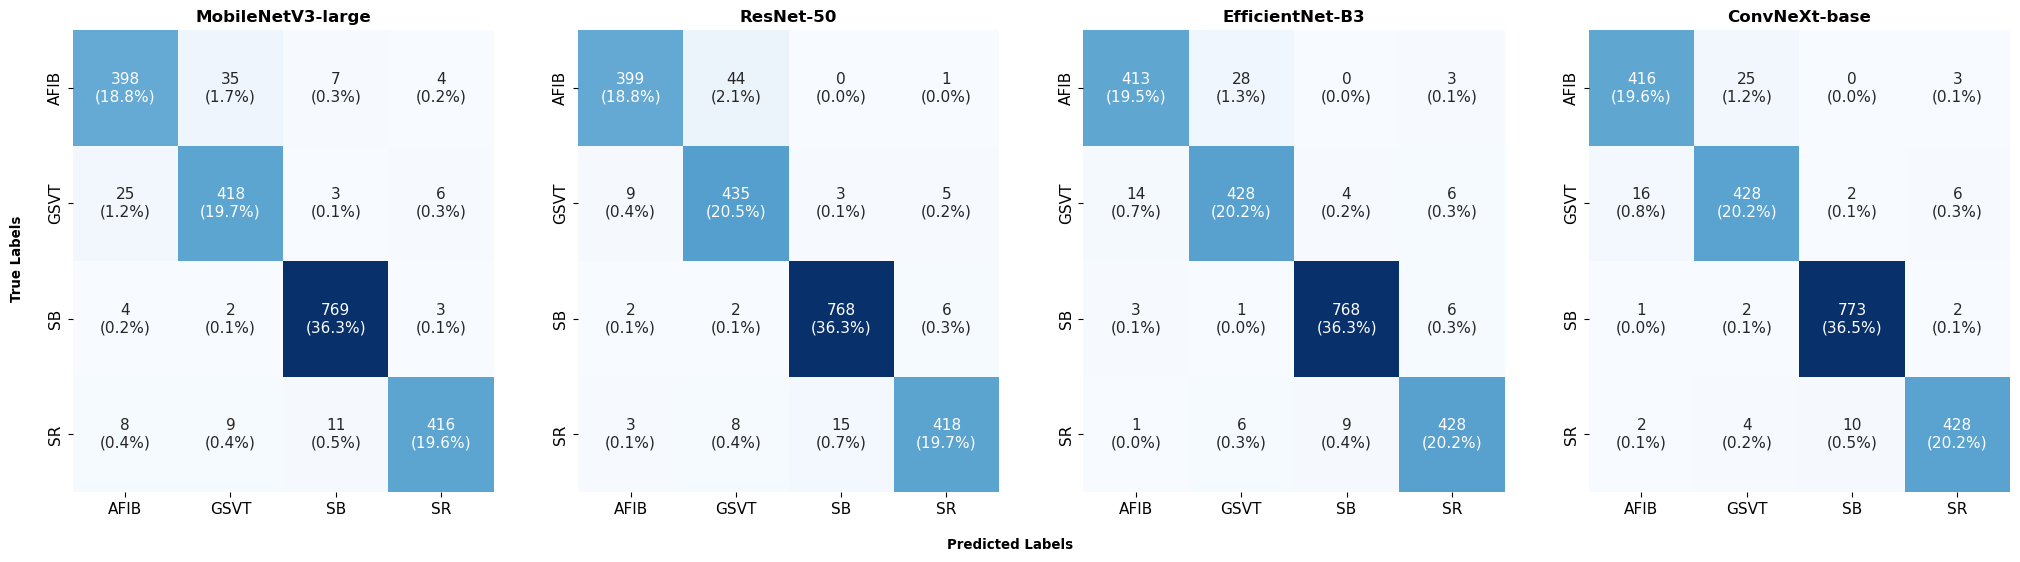

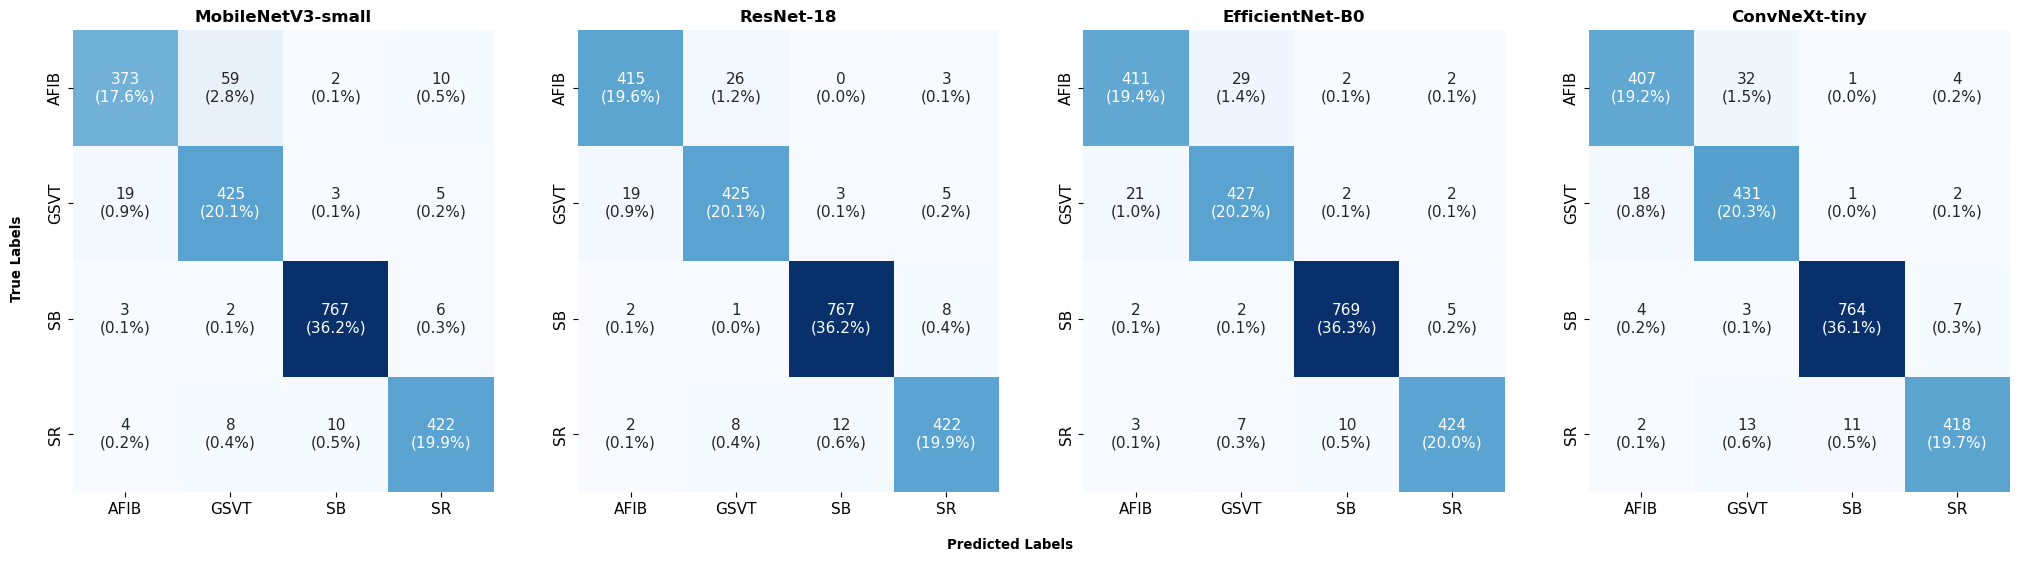

In [80]:
model_arch_list_big = ['mobilenetv3large', 'resnet50', 'efficientnetb3', 'convnextbase']
fig = plt.figure(figsize=(25, 6))
plot_num = 1
for arch in model_arch_list_big:
    axes = fig.add_subplot(1, 4, plot_num)
    get_model_confusion_matrix(final_results_dir, arch, 'config1_adj', l1_rhythm_encoder, display_ax=axes)
    axes.set_title(arch_name_dict[arch], fontsize=12, fontweight='heavy')
    axes.tick_params(labelsize=11)
    plot_num += 1
fig.supylabel("True Labels", x=0.1, fontweight='heavy')
fig.supxlabel("Predicted Labels", fontweight='heavy')
plt.show()

model_arch_list_small = ['mobilenetv3small', 'resnet18', 'efficientnetb0', 'convnexttiny']
fig = plt.figure(figsize=(25, 6))
plot_num = 1
for arch in model_arch_list_small:
    axes = fig.add_subplot(1, 4, plot_num)
    get_model_confusion_matrix(final_results_dir, arch, 'config1_adj', l1_rhythm_encoder, display_ax=axes)
    axes.set_title(arch_name_dict[arch], fontsize=12, fontweight='heavy')
    axes.tick_params(labelsize=11)
    plot_num += 1
fig.supylabel("True Labels", x=0.1, fontweight='heavy')
fig.supxlabel("Predicted Labels", fontweight='heavy')
plt.show()

##### **4.1.3.b.** Evaluation Metrics by Model and Class

In [81]:
arch_sort = [('mobilenetv3', 'mobilenetv3small'), ('mobilenetv3', 'mobilenetv3large'), ('resnet', 'resnet18'), ('resnet', 'resnet50'),
            ('efficientnet', 'efficientnetb0'), ('efficientnet', 'efficientnetb3'), ('convnext', 'convnexttiny'), ('convnext', 'convnextbase')]
metrics_sort = [(lab, metric) for lab in ['AFIB', 'GSVT', 'SB', 'SR'] for metric in ['f1', 'recall', 'precision']]


analysis_df.query(
    "dataset_config == 'config1' and metric_name in ['recall', 'precision', 'f1'] and dataset_type == 'test' and label_name != 'macro_avg'"
).pivot(
    index=['label_name', 'metric_name'],
    columns=['arch_family', 'model_arch'],
    values='results'
).reindex(metrics_sort, columns=arch_sort).round(4)

arch_family                 mobilenetv3                    resnet           \
model_arch             mobilenetv3small mobilenetv3large resnet18 resnet50   
label_name metric_name                                                       
AFIB       f1                    0.8849           0.9056   0.9410   0.9312   
           recall                0.8401           0.8964   0.9347   0.8986   
           precision             0.9348           0.9149   0.9475   0.9661   
GSVT       f1                    0.8985           0.9127   0.9320   0.9245   
           recall                0.9403           0.9248   0.9403   0.9624   
           precision             0.8603           0.9009   0.9239   0.8896   
SB         f1                    0.9833           0.9809   0.9833   0.9821   
           recall                0.9859           0.9884   0.9859   0.9871   
           precision             0.9808           0.9734   0.9808   0.9771   
SR         f1                    0.9515           0.9530   0.9569   0.9565   
           recall                0.9505           0.9369   0.9505   0.9414   
           precision             0.9526           0.9697   0.9635   0.9721   

arch_family              efficientnet                    convnext               
model_arch             efficientnetb0 efficientnetb3 convnexttiny convnextbase  
label_name metric_name                                                          
AFIB       f1                  0.9330         0.9440       0.9303       0.9465  
           recall              0.9257         0.9302       0.9167       0.9369  
           precision           0.9405         0.9582       0.9443       0.9563  
GSVT       f1                  0.9313         0.9355       0.9259       0.9396  
           recall              0.9447         0.9469       0.9535       0.9469  
           precision           0.9183         0.9244       0.8998       0.9325  
SB         f1                  0.9853         0.9852       0.9826       0.9891  
           recall              0.9884         0.9871       0.9820       0.9936  
           precision           0.9821         0.9834       0.9833       0.9847  
SR         f1                  0.9669         0.9651       0.9554       0.9694  
           recall              0.9550         0.9640       0.9414       0.9640  
           precision           0.9792         0.9661       0.9698       0.9749

# **4.2.** Supplementary Analyses

### **4.2.1.** Training and Validation Learning Curves

In [82]:
# Consolidate learning and validation curves.
folder_list = [folder_name for folder_name in sorted(os.listdir(final_results_dir)) if not folder_name.startswith('.') if not folder_name.endswith((".csv", "_l2", ".md"))]

history_df = pd.DataFrame()

for folder_name in folder_list:
    model_arch = folder_name.split("_")[0]
    dataset_config = folder_name.split("_")[1]

    history_file = os.path.join(final_results_dir, folder_name, 'model_retrained_history.json')
    with open(history_file, 'r') as file:
        history_contents = json.load(file)
    
    train_df = pd.DataFrame(history_contents['best_train_history']['train']['f1'], columns=['f1_score'])
    train_df['model_arch'] = model_arch
    train_df['dataset_config'] = dataset_config
    train_df['dataset_type'] = 'train'

    val_df = pd.DataFrame(history_contents['best_train_history']['val']['f1'], columns=['f1_score'])
    val_df['model_arch'] = model_arch
    val_df['dataset_config'] = dataset_config
    val_df['dataset_type'] = 'val'

    history_df = pd.concat([history_df, train_df, val_df], ignore_index=False)

history_df = history_df.reset_index().rename(columns={'index':'epoch_num'})

arch_dict = {
    'resnet18': ['resnet', 'Small Variant'], 'resnet50': ['resnet', 'Large Variant'],
    'efficientnetb0': ['efficientnet', 'Small Variant'], 'efficientnetb3': ['efficientnet', 'Large Variant'],
    'convnexttiny': ['convnext', 'Small Variant'], 'convnextbase': ['convnext', 'Large Variant'],
    'mobilenetv3small': ['mobilenetv3', 'Small Variant'], 'mobilenetv3large': ['mobilenetv3', 'Large Variant']
}
history_df['arch_family'] = history_df['model_arch'].map({key: value[0] for  key, value in arch_dict.items()})
history_df['arch_variant'] = history_df['model_arch'].map({key: value[1] for  key, value in arch_dict.items()})


In [94]:
family_sort = ['mobilenetv3', 'resnet', 'efficientnet', 'convnext']

line_chart = alt.Chart(history_df).mark_line().encode(
    x = alt.X('epoch_num:Q', title='Number of Epochs'),
    y = alt.Y('f1_score:Q', title='F1 Score'),
    color = alt.Color('dataset_type:N', legend=alt.Legend(orient='bottom', direction='horizontal', labelExpr="datum.label == 'train' ? 'Training Set' : 'Test Set'"), title='Dataset Type', scale=alt.Scale(range=["#79BFE2", "#801F2F"]))
).transform_filter(
    alt.datum.dataset_config == 'config1'
).facet(
    column = alt.Column('arch_family', sort=family_sort, title='CNN Architecture Family', header=alt.Header(titleOrient="bottom", labelOrient="bottom", labelFontSize=14, titleFontSize=14)),
    row = alt.Row('arch_variant:O', title='Architecture Variant', header=alt.Header(labelFontSize=14, titleFontSize=14))
)

line_chart.configure_axis(
    titleFontSize=11,
    labelFontSize=11
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    padding=5
)

alt.FacetChart(...)

### **4.2.2.** Latency Metrics

In [100]:
# Get latency data.
latency_df = analysis_df[analysis_df['metric_name'].isin(['total_inference_time', 'throughput', 'total_train_time', 'per_epoch_train_time'])].copy()
latency_df = latency_df.pivot(index = ['arch_family', 'arch_variant', 'model_arch', 'model_arch_label', 'dataset_config', 'dataset_type'], columns = 'metric_name', values = 'results').reset_index()

##### **4.2.2.a.** Per-epoch and Total Training Time

In [101]:
train_chart_small = alt.Chart(latency_df).mark_point(
    filled = False,
    size = 75
).encode(
    x = alt.X('per_epoch_train_time:Q', title='Time Taken per Epoch (seconds)', scale=alt.Scale(domain=[0, 70])),
    y = alt.Y('y:Q', title='Total Training Time (minutes)'),
    shape = alt.Shape('arch_variant'),
    color = alt.Color('arch_family')
).transform_filter(
    alt.datum.dataset_config == 'config1',
    alt.datum.dataset_type == 'train',
    alt.datum.arch_variant == 'small'
).transform_calculate(
    y = alt.datum.total_train_time / 60
)

train_chart_big = alt.Chart(latency_df).mark_point(
    filled = True,
    size = 65
).encode(
    x = alt.X('per_epoch_train_time:Q', title='Time Taken per Epoch (seconds)', scale=alt.Scale(domain=[0, 70])),
    y = alt.Y('y:Q', title='Total Training Time (minutes)'),
    shape = alt.Shape('arch_variant', legend=alt.Legend(orient='bottom', direction='vertical', title='Architecture Variant', labelExpr="datum.label == 'big' ? 'Large Variant' : 'Small Variant'")),
    color = alt.Color('arch_family', legend=alt.Legend(orient='bottom', direction='vertical', title='Architecture Family'), scale=alt.Scale(scheme='set2'))
).transform_filter(
    alt.datum.dataset_config == 'config1',
    alt.datum.dataset_type == 'train',
    alt.datum.arch_variant == 'big'
).transform_calculate(
    y = alt.datum.total_train_time / 60
)

(train_chart_small + train_chart_big).properties(
    width = 450,
    height = 350
).properties(
    width = 410,
    height = 250
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    padding=5
)

alt.LayerChart(...)

##### **4.2.2.b.** Inference Throughput

In [102]:
throughput_sort = latency_df.query(
    "dataset_config == 'config1' and dataset_type == 'test'"
).sort_values('throughput').model_arch_label.tolist()

alt.Chart(latency_df).mark_bar().encode(
    x = alt.X('model_arch_label', sort=throughput_sort, title='CNN Architecture'),
    y = alt.Y('throughput', title='Throughput (Images per second)'),
    color = alt.Color('arch_family', title='Architecture Family', legend=alt.Legend(orient='bottom', direction='horizontal'), scale=alt.Scale(scheme='set2'))
).transform_filter(
    alt.datum.dataset_config == 'config1',
    alt.datum.dataset_type == 'test'
).properties(
    width = 410,
    height = 250
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    padding=5
)

alt.Chart(...)

### **4.2.3.** Hyperparameter Optimisation

##### **4.2.3.a.** Hyperparameter Importance

In [110]:
# Define a function to consolidate the result of all optuna trials.
def get_optuna_study(model_arch, train_stage, dataset_config):
    study_name = f'optuna_ecg_{model_arch}_{train_stage}_{dataset_config}'
    optuna_res_dir = os.path.join(project_dir, 'optuna', f'{model_arch}_{train_stage}_{dataset_config}', "optuna-results")
    storage_path = f"sqlite:///{os.path.join(optuna_res_dir, 'optuna_study.db')}"

    study = optuna.load_study(study_name=study_name, storage=storage_path)
    return study

# Store the studies in a list.
studies = []
subplot_titles = []
model_arch_list = ['mobilenetv3large', 'resnet50', 'efficientnetb3', 'convnextbase', 'mobilenetv3small', 'resnet18', 'efficientnetb0', 'convnexttiny']

for arch in model_arch_list:
    study = get_optuna_study(arch, 'full', 'config1')
    studies.append(study)
    
    # Get the number of completed trials
    n_trials = len(study.trials)
    
    # Format the title string
    title = f'{arch_name_dict[arch]} (n = {n_trials} trials)'
    subplot_titles.append(title)

fig = make_subplots(rows=2, cols=4, subplot_titles=subplot_titles, horizontal_spacing=0.08, vertical_spacing=0.1)
for i, study in enumerate(studies):
    temp_fig = plot_param_importances(study, evaluator=optuna.importance.PedAnovaImportanceEvaluator(baseline_quantile=0.1, evaluate_on_local=True))
    row = (i // 4) + 1
    col = (i % 4) + 1
    for trace in temp_fig.data:
        trace.marker.color = "#919BA3"
        fig.add_trace(trace, row=row, col=col)
    
fig.update_layout(
    height=800,
    width=1500,
    showlegend=False,
    font=dict(
        family="Roboto",
        size=13,
        color="black"
    ),
    xaxis=dict(title_font=dict(size=10), tickfont=dict(size=10)),
    yaxis=dict(title_font=dict(size=10), tickfont=dict(size=10))
)

for annotation in fig.layout.annotations:
    annotation['font']['size'] = 15

fig.show()

/var/folders/11/db6fxs691q30j1ft8bcn5w540000gn/T/ipykernel_22069/2249758856.py:28: ExperimentalWarning:

PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.



##### **4.2.3.b.** Final Hyperparameter Values

In [111]:
folder_list = [folder_name for folder_name in sorted(os.listdir(final_results_dir)) if not folder_name.startswith('.') if not folder_name.endswith((".csv", "_l2", ".md"))]

best_configs_df = pd.DataFrame()

for folder_name in folder_list:
    best_config_file = os.path.join(final_results_dir, folder_name, 'best_model_config.json')
    with open(best_config_file, 'r') as file:
        best_config_contents = json.load(file)
    
    config_df = pd.DataFrame.from_dict({best_config_contents['model_arch']: best_config_contents}, orient='index').reset_index(drop=True)
    best_configs_df = pd.concat([best_configs_df, config_df], ignore_index=True)

model_sort = ['mobilenetv3small', 'mobilenetv3large', 'resnet18', 'resnet50', 'efficientnetb0', 'efficientnetb3', 'convnexttiny', 'convnextbase']
hyperparam_list = ['model_arch', 'dataset_ver', 'optimizer_name', 'opt_learning_rate', 'opt_weight_decay', 'scheduler_name', 'batch_size']
best_configs_df['model_arch'] = pd.Categorical(best_configs_df['model_arch'], categories=model_sort, ordered=True)
best_configs_df.loc[:, hyperparam_list].query(
    "dataset_ver == 'config1'"
).sort_values(by='model_arch').drop('dataset_ver', axis=1).set_index('model_arch')

,optimizer_name,opt_learning_rate,opt_weight_decay,scheduler_name,batch_size
model_arch,,,,,
mobilenetv3small,AdamW,0.0050,0.000000e+00,ReduceLROnPlateau,32
mobilenetv3large,AdamW,0.0070,7.000000e-04,ReduceLROnPlateau,64
resnet18,SGD,0.0050,1.000000e-02,ReduceLROnPlateau,32
resnet50,AdamW,0.0015,1.000000e-02,ReduceLROnPlateau,32
efficientnetb0,AdamW,0.0060,0.000000e+00,ReduceLROnPlateau,32
efficientnetb3,AdamW,0.0030,1.000000e-04,ReduceLROnPlateau,32
convnexttiny,AdamW,0.0003,5.000000e-08,ReduceLROnPlateau,32
convnextbase,AdamW,0.0005,1.000000e-06,StepLR,64


### **4.2.4.** Training with Different ECG Formats

##### **4.2.4.a.** Training and Validation Curves for Config 2

In [121]:
family_sort = ['mobilenetv3', 'resnet', 'efficientnet', 'convnext']

line_chart = alt.Chart(history_df).mark_line().encode(
    x = alt.X('epoch_num:Q', title='Number of Epochs'),
    y = alt.Y('f1_score:Q', title='F1 Score'),
    color = alt.Color('dataset_type:N', legend=alt.Legend(orient='bottom', direction='horizontal', labelExpr="datum.label == 'train' ? 'Training Set' : 'Test Set'"), title='Dataset Type', scale=alt.Scale(range=["#79BFE2", "#801F2F"])),
    column = alt.Column('model_arch', title='CNN Architecture', sort=['resnet18', 'convnextbase'], header=alt.Header(titleOrient="bottom", labelOrient="bottom", labelFontSize=14, titleFontSize=14))
).transform_filter(
    alt.datum.dataset_config == 'config2'
)

line_chart.configure_axis(
    titleFontSize=12,
    labelFontSize=12
).configure_legend(
    titleFontSize=11,
    labelFontSize=11,
    padding=5
)

alt.Chart(...)

##### **4.2.4.b.** Evaluation Metrics Comparison for Config 2

In [24]:
metrics_sort = ['f1', 'recall', 'precision', 'accuracy', 'auroc']

overall_metrics_df_2 = analysis_df.query(
    "dataset_config == 'config2' and dataset_type == 'test' and label_name == 'macro_avg'"
).copy()
overall_metrics_df_2 = overall_metrics_df_2.loc[:, ['arch_family', 'arch_variant', 'model_arch', 'metric_name', 'results']].copy()

overall_metrics_df_2.pivot(
    index = 'metric_name',
    columns = 'model_arch',
    values = 'results'
).drop(
    ['n_samples', 'throughput', 'total_inference_time'], axis=0
).loc[metrics_sort,['resnet18', 'convnextbase']].round(4)

model_arch,resnet18,convnextbase
metric_name,,
f1,0.9517,0.9559
recall,0.9515,0.9555
precision,0.9523,0.9569
accuracy,0.9570,0.9606
auroc,0.9938,0.9947


# **4.3.** Robustness and Generalisation Experiments

In [123]:
# Consolidate all sensitivity analysis results.
folder_list = [folder_name for folder_name in sorted(os.listdir(final_results_dir)) if not folder_name.startswith('.') if folder_name.startswith("convnextbase")]

consol_hist_df = pd.DataFrame()  # Consolidate training and validation curves.
consol_metrics = []  # Consolidate evaluation metrics.

for folder_name in folder_list:
    model_arch = folder_name.split("_")[0]
    dataset_config = "_".join(folder_name.split("_")[1:])

    seed_run_exp_dir = os.path.join(final_results_dir, folder_name, "seed-runs-mod")

    # Consol training and validation curves.
    seed_hist_dir = os.path.join(seed_run_exp_dir, "history-results")
    hist_list = [file for file in sorted(os.listdir(seed_hist_dir)) if not file.endswith(".DS_Store")]
    for hist_file_name in hist_list:
        hist_file_path = os.path.join(seed_hist_dir, hist_file_name)
        with open(hist_file_path, 'r') as file:
            hist_contents = json.load(file)
        
        hist_df = pd.DataFrame({
            'train': hist_contents['best_train_history']['train']['f1'],
            'val': hist_contents['best_train_history']['val']['f1']
        }).reset_index(names='num_epoch')
        hist_df['seed'] = int(hist_file_name.split("_")[-2])
        hist_df['model_arch'] = model_arch
        hist_df['dataset_config'] = dataset_config

        consol_hist_df = pd.concat([consol_hist_df, hist_df], ignore_index=True)
    
    # Consol evaluation metrics.
    seed_metrics_dir = os.path.join(seed_run_exp_dir, "eval-results")
    metrics_list = [file for file in sorted(os.listdir(seed_metrics_dir)) if not file.endswith(".DS_Store")]
    for metrics_file_name in metrics_list:
        metrics_file_path = os.path.join(seed_metrics_dir, metrics_file_name)
        with open(metrics_file_path, 'r') as file:
            metrics_contents = json.load(file)
        
        for dataset_type, metric_type in metrics_contents.items():
            for metric_name, values in metric_type.items():
                if isinstance(values, dict):
                    for label_name, label_res in values.items():
                        row = {
                            'model_arch': model_arch,
                            'dataset_config': dataset_config,
                            'dataset_type': dataset_type,
                            'seed': int(metrics_file_name.split("_")[3]),
                            'metric_name': metric_name,
                            'label_name': label_name,
                            'results': label_res,
                        }
                        consol_metrics.append(row)
                else:
                    row = {
                        'model_arch': model_arch,
                        'dataset_config': dataset_config,
                        'dataset_type': dataset_type,
                        'seed': int(metrics_file_name.split("_")[3]),
                        'metric_name': metric_name,
                        'label_name': 'macro_avg',
                        'results': values,
                    }
                    consol_metrics.append(row)

consol_hist_df = consol_hist_df.sort_values('seed').reset_index(drop=True).copy()
consol_metrics_df = pd.DataFrame(consol_metrics)

agg_df = consol_hist_df.melt(
    id_vars = ['model_arch', 'dataset_config', 'seed', 'num_epoch'],
    value_vars = ['train', 'val'],
    var_name = 'dataset_type',
    value_name = 'f1_score'
).groupby(['model_arch', 'dataset_config', 'dataset_type', 'num_epoch']).agg(
    mean_f1=('f1_score', 'mean'),
    std_f1=('f1_score', 'std'),
    min_f1=('f1_score', 'min'),
    max_f1=('f1_score', 'max')
).reset_index().copy()

# Calculate upper and lower bounds for the area
agg_df['lower_1std'] = agg_df['mean_f1'] - agg_df['std_f1']
agg_df['upper_1std'] = (agg_df['mean_f1'] + agg_df['std_f1']).clip(upper=1)

### **4.3.1.** Robustness to Different Random Seeds

##### **4.3.1.a.** Histogram of F1 Scores on Hold-out Test Set

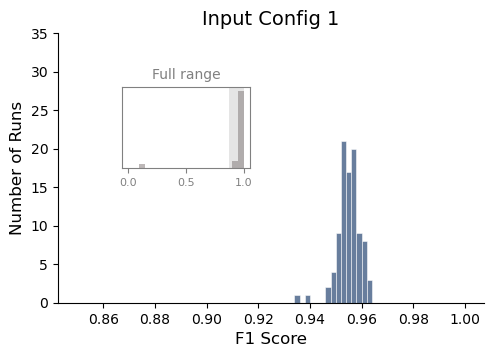

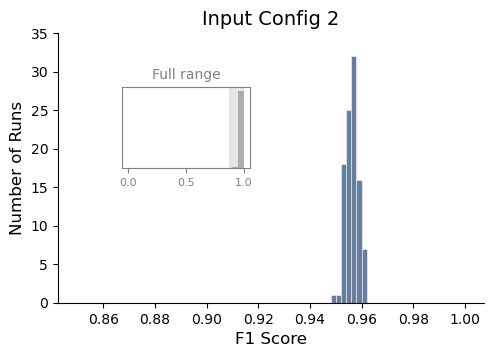

In [130]:
filtered_df = consol_metrics_df.query(
    "dataset_type == 'test' and metric_name == 'f1' and label_name == 'macro_avg' and dataset_config in ['config1_adj', 'config2_adj']"
).reset_index(drop=True).copy()

for i, (config_name, sub_df) in enumerate(filtered_df.groupby('dataset_config')):
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    sns.histplot(sub_df, x='results', bins=75, binrange=(0.85, 1.0), stat='count', color="#36537C", edgecolor='white', ax=ax)
    ax.set_title(f'Input Config {i+1}', fontsize=14)
    ax.set_ylim(0,35)
    ax.set_ylabel('Number of Runs', fontsize=12)
    ax.set_xlabel('F1 Score', fontsize=12)
    ax.tick_params(labelsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Insert inset plot.
    ax_inset = ax.inset_axes([0.15, 0.5, 0.3, 0.3])
    sns.histplot(data=sub_df, x="results", bins=20, binrange=(0, 1), ax=ax_inset, color="#A7A0A0", edgecolor=None)
    ax_inset.axvspan(0.87, 1.0, color="gray", alpha=0.2, lw=0)
    ax_inset.set_xticks([0, 0.5, 1.0])
    ax_inset.tick_params(axis='x', colors='gray')
    ax_inset.set_yticks([])
    ax_inset.set_title("Full range", fontsize=10, color='gray')
    ax_inset.set_xlabel("")
    ax_inset.set_ylabel("")
    for spine in ax_inset.spines.values():
        spine.set_edgecolor("gray")
    
    plt.show()

##### **4.3.1.b.** Random Seed vs F1 Score

In [133]:
filtered_df = consol_metrics_df.query(
    "dataset_type == 'test' and metric_name == 'f1' and label_name == 'macro_avg' and dataset_config in ['config1_adj', 'config2_adj']"
).reset_index(drop=True).copy()

for i, dt_config in enumerate(['config1_adj', 'config2_adj']):
    dt_chart = alt.Chart(filtered_df).mark_point().encode(
        x = alt.X('seed:O', axis=alt.Axis(labels=False), title='Random Seed'),
        y = alt.Y('results:Q', scale=alt.Scale(domain=(0.93, 0.97)), title='F1 Score'),
    ).transform_filter(
        alt.datum.dataset_config == dt_config,
        alt.datum.results > 0.9
    ).properties(
        width = 400,
        height = 350,
        title = f'Input Config {i+1}'
    )

    dt_chart.properties(
        width = 450,
        height = 350
    ).properties(
        width = 410,
        height = 250
    ).configure_axis(
        titleFontSize=14,
        labelFontSize=12
    ).configure_legend(
        titleFontSize=14,
        labelFontSize=12,
        padding=5
    ).configure_title(
        fontSize=14
    ).show()

alt.Chart(...)

alt.Chart(...)

##### **4.3.1.d.** Summary Statistics of Evaluation on Test Set

In [134]:
consol_metrics_df.query(
    "dataset_type == 'test' and metric_name == 'f1' and dataset_config in ['config1_adj', 'config2_adj']"
).pivot_table(
    index=['model_arch', 'dataset_config', 'label_name'],
    values='results',
    aggfunc=['min', 'mean', 'median', 'max', 'std']
).round(4)

min    mean  median     max     std
                                       results results results results results
model_arch   dataset_config label_name                                        
convnextbase config1_adj    AFIB        0.0000  0.8903  0.9383  0.9531  0.2055
                            GSVT        0.0000  0.8852  0.9319  0.9462  0.2042
                            SB          0.5373  0.9624  0.9846  0.9898  0.0980
                            SR          0.0000  0.9172  0.9653  0.9738  0.2115
                            macro_avg   0.1343  0.9138  0.9545  0.9624  0.1798
             config2_adj    AFIB        0.9225  0.9414  0.9413  0.9499  0.0049
                            GSVT        0.9209  0.9331  0.9328  0.9416  0.0039
                            SB          0.9824  0.9861  0.9862  0.9891  0.0013
                            SR          0.9594  0.9643  0.9643  0.9705  0.0025
                            macro_avg   0.9487  0.9562  0.9562  0.9612  0.0024

In [29]:
# Excluding the five low performing runs for Config 1.
consol_metrics_df.query(
    "dataset_type == 'test' and metric_name == 'f1' and dataset_config == 'config1_adj' and results > 0.9"
).pivot_table(
    index=['model_arch', 'dataset_config', 'label_name'],
    values='results',
    aggfunc=['min', 'mean', 'median', 'max', 'std']
).round(4)

min    mean  median     max     std
                                       results results results results results
model_arch   dataset_config label_name                                        
convnextbase config1_adj    AFIB        0.9155  0.9380  0.9387  0.9531  0.0072
                            GSVT        0.9140  0.9322  0.9325  0.9462  0.0062
                            SB          0.9768  0.9847  0.9847  0.9898  0.0021
                            SR          0.9530  0.9654  0.9658  0.9738  0.0041
                            macro_avg   0.9343  0.9548  0.9550  0.9624  0.0044

##### **4.3.1.e.** Histogram of Maximum Epoch Trained

In [136]:
epoch_df = consol_hist_df.query(
    "dataset_config in ['config1_adj', 'config2_adj']"
).melt(
    id_vars = ['model_arch', 'dataset_config', 'seed', 'num_epoch'],
    value_vars = ['train'],
    var_name = 'dataset_type',
    value_name = 'f1_score'
).groupby(['model_arch', 'dataset_config', 'dataset_type', 'seed']).agg(
    max_epoch=('num_epoch', 'max')
).reset_index().copy()

epoch_df['max_epoch'] = epoch_df['max_epoch'] + 1

for i, dt_config in enumerate(['config1_adj', 'config2_adj']):
    dt_chart = alt.Chart(epoch_df).mark_bar().encode(
        x = alt.X('max_epoch:O', bin=alt.Bin(maxbins=20), title='Max Trained Epoch'),
        y = alt.Y('count()', aggregate='count', title="Frequency")
    ).transform_filter(
        alt.datum.dataset_config == dt_config
    ).properties(
        width = 400,
        height = 350,
        title = f'Input Config {i+1}'
    )
    
    dt_chart.properties(
        width = 450,
        height = 350
    ).properties(
        width = 410,
        height = 250
    ).configure_axis(
        titleFontSize=14,
        labelFontSize=12
    ).configure_legend(
        titleFontSize=14,
        labelFontSize=12,
        padding=5
    ).configure_title(
        fontSize=14
    ).show()

alt.Chart(...)

alt.Chart(...)

##### **4.3.1.f.** Training and Validation Curves of Low-performing Runs for Config 1

In [31]:
filtered_df = consol_hist_df.query(
    "seed in [2310, 2856, 3150, 3234, 3318] and dataset_config == 'config1_adj'"
).melt(
    id_vars = ['seed', 'num_epoch'],
    value_vars = ['train', 'val'],
    value_name = 'f1_score',
    var_name = 'dataset_type'
)

alt.Chart(filtered_df).mark_line().encode(
    x = alt.X('num_epoch:Q', title='Number of Epochs'),
    y = alt.Y('f1_score:Q', title='F1 Score'),
    color = alt.Color('dataset_type:N', legend=alt.Legend(orient='bottom', direction='horizontal', labelExpr="datum.label == 'train' ? 'Training Set' : 'Test Set'"), title='Dataset Type', scale=alt.Scale(range=["#79BFE2", "#801F2F"])),
).facet(
    column=alt.Column('seed', title='Random Seed Number')
)

alt.FacetChart(...)

### **4.3.2.** Generalisability to Granular Labels

##### **4.3.2.a.** Summary Statistics of Evaluation on Test Set

In [32]:
consol_metrics_df.query(
    "dataset_type == 'test' and metric_name == 'f1' and dataset_config in ['config1_adj_l2', 'config2_adj_l2']"
).pivot_table(
    index=['model_arch', 'dataset_config', 'label_name'],
    values='results',
    aggfunc=['min', 'mean', 'median', 'max', 'std']
).round(4)

min    mean  median     max     std
                                       results results results results results
model_arch   dataset_config label_name                                        
convnextbase config1_adj_l2 AF          0.0000  0.6131  0.6463  0.7119  0.1324
                            AFIB        0.0000  0.8827  0.9188  0.9346  0.1821
                            AT          0.0000  0.2403  0.2424  0.4186  0.0901
                            AVNRT       0.0000  0.0140  0.0000  0.5000  0.0756
                            AVRT        0.0000  0.0000  0.0000  0.0000  0.0000
                            SAAWR       0.0000  0.0000  0.0000  0.0000  0.0000
                            SB          0.5373  0.9662  0.9841  0.9891  0.0885
                            SI          0.0000  0.6716  0.7045  0.7857  0.1441
                            SR          0.0000  0.8976  0.9355  0.9519  0.1852
                            ST          0.0000  0.9168  0.9542  0.9636  0.1891
                            SVT         0.0000  0.8442  0.8787  0.9130  0.1748
                            macro_avg   0.0488  0.5497  0.5678  0.6151  0.1040
             config2_adj_l2 AF          0.5113  0.6043  0.6092  0.6727  0.0329
                            AFIB        0.9077  0.9233  0.9241  0.9363  0.0062
                            AT          0.0882  0.2188  0.2250  0.3750  0.0647
                            AVNRT       0.0000  0.0108  0.0000  0.2727  0.0437
                            AVRT        0.0000  0.0000  0.0000  0.0000  0.0000
                            SAAWR       0.0000  0.0000  0.0000  0.0000  0.0000
                            SB          0.9760  0.9850  0.9853  0.9875  0.0018
                            SI          0.5546  0.7029  0.7097  0.7762  0.0370
                            SR          0.9231  0.9379  0.9380  0.9499  0.0056
                            ST          0.9324  0.9528  0.9532  0.9633  0.0054
                            SVT         0.8224  0.8701  0.8713  0.9104  0.0141
                            macro_avg   0.5438  0.5642  0.5646  0.5869  0.0088

##### **4.3.2.b.** Accuracy Score Comparison

In [33]:
consol_metrics_df.query(
    "dataset_type == 'test' and metric_name in ['f1', 'accuracy'] and label_name == 'macro_avg'"
).pivot_table(
    index=['metric_name', 'dataset_config', 'label_name'],
    values='results',
    aggfunc=['min', 'mean', 'median', 'max', 'std']
).round(4)

min    mean  median     max     std
                                      results results results results results
metric_name dataset_config label_name                                        
accuracy    config1_adj    macro_avg   0.3673  0.9298  0.9594  0.9665  0.1297
            config1_adj_l2 macro_avg   0.3673  0.9005  0.9228  0.9301  0.1100
            config2_adj    macro_avg   0.9547  0.9608  0.9608  0.9653  0.0021
            config2_adj_l2 macro_avg   0.9079  0.9220  0.9228  0.9289  0.0040
f1          config1_adj    macro_avg   0.1343  0.9138  0.9545  0.9624  0.1798
            config1_adj_l2 macro_avg   0.0488  0.5497  0.5678  0.6151  0.1040
            config2_adj    macro_avg   0.9487  0.9562  0.9562  0.9612  0.0024
            config2_adj_l2 macro_avg   0.5438  0.5642  0.5646  0.5869  0.0088

##### **4.3.2.b.** Histogram of F1 Scores on Hold-out Test Set

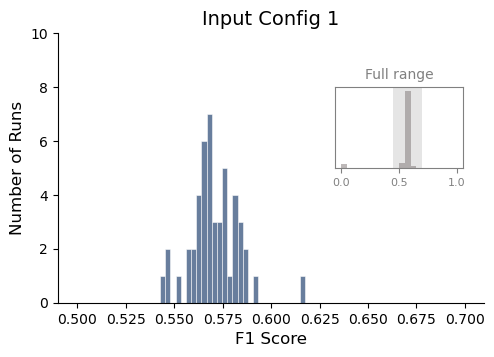

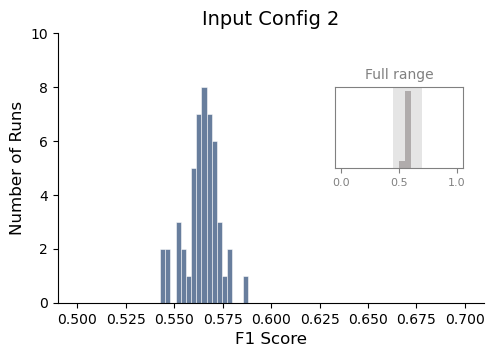

In [138]:
filtered_df = consol_metrics_df.query(
    "dataset_type == 'test' and metric_name == 'f1' and label_name == 'macro_avg' and dataset_config in ['config1_adj_l2', 'config2_adj_l2']"
).reset_index(drop=True).copy()

for i, (config_name, sub_df) in enumerate(filtered_df.groupby('dataset_config')):
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    sns.histplot(sub_df, x='results', bins=75, binrange=(0.5, 0.7), stat='count', color="#36537C", edgecolor='white', ax=ax)
    ax.set_title(f'Input Config {i+1}', fontsize=14)
    ax.set_ylim(0,10)
    ax.set_ylabel('Number of Runs', fontsize=12)
    ax.set_xlabel('F1 Score', fontsize=12)
    ax.tick_params(labelsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Insert inset plot.
    ax_inset = ax.inset_axes([0.65, 0.5, 0.3, 0.3])
    sns.histplot(data=sub_df, x="results", bins=20, binrange=(0, 1), ax=ax_inset, color="#A7A0A0", edgecolor=None)
    ax_inset.axvspan(0.45, 0.7, color="gray", alpha=0.2, lw=0)
    ax_inset.set_xticks([0, 0.5, 1.0])
    ax_inset.tick_params(axis='x', colors='gray')
    ax_inset.set_yticks([])
    ax_inset.set_title("Full range", fontsize=10, color='gray')
    ax_inset.set_xlabel("")
    ax_inset.set_ylabel("")
    for spine in ax_inset.spines.values():
        spine.set_edgecolor("gray")
    
    plt.show()

# **5.1.** Appendix

### **5.1.1.** Training with Different ECG Formats

##### **5.1.1.a.** Confusion Matrices

In [139]:
# Get dataset metada.
lmdb_path, csv_path = ecg_utils.get_dataset_paths(
    main_data_dir,
    'resnet18',
    'config2_adj',
    'test'
)
labels_keys_df = pd.read_csv(csv_path)

# Consolidate model predictions to differentiate the results between the different layouts.
folder_list = [folder_name for folder_name in sorted(os.listdir(final_results_dir)) if not folder_name.startswith('.') if folder_name.endswith("_config2_adj")]

consol_outputs_df = pd.DataFrame()
for folder_name in folder_list:
    model_arch = folder_name.split("_")[0]
    dataset_config = folder_name.split("_")[1]
    pred_json_file = os.path.join(final_results_dir, folder_name, "model_retrained_predictions.json")
    with open(pred_json_file, 'r') as file:
        pred_contents = json.load(file)

    output_df = pd.DataFrame(pred_contents['test']).drop('label_probs', axis=1).join(labels_keys_df)
    output_df['model_arch'] = model_arch
    output_df = output_df.drop(['versionname', 'key', 'label'], axis=1).copy()
    consol_outputs_df = pd.concat([consol_outputs_df, output_df], ignore_index=True)

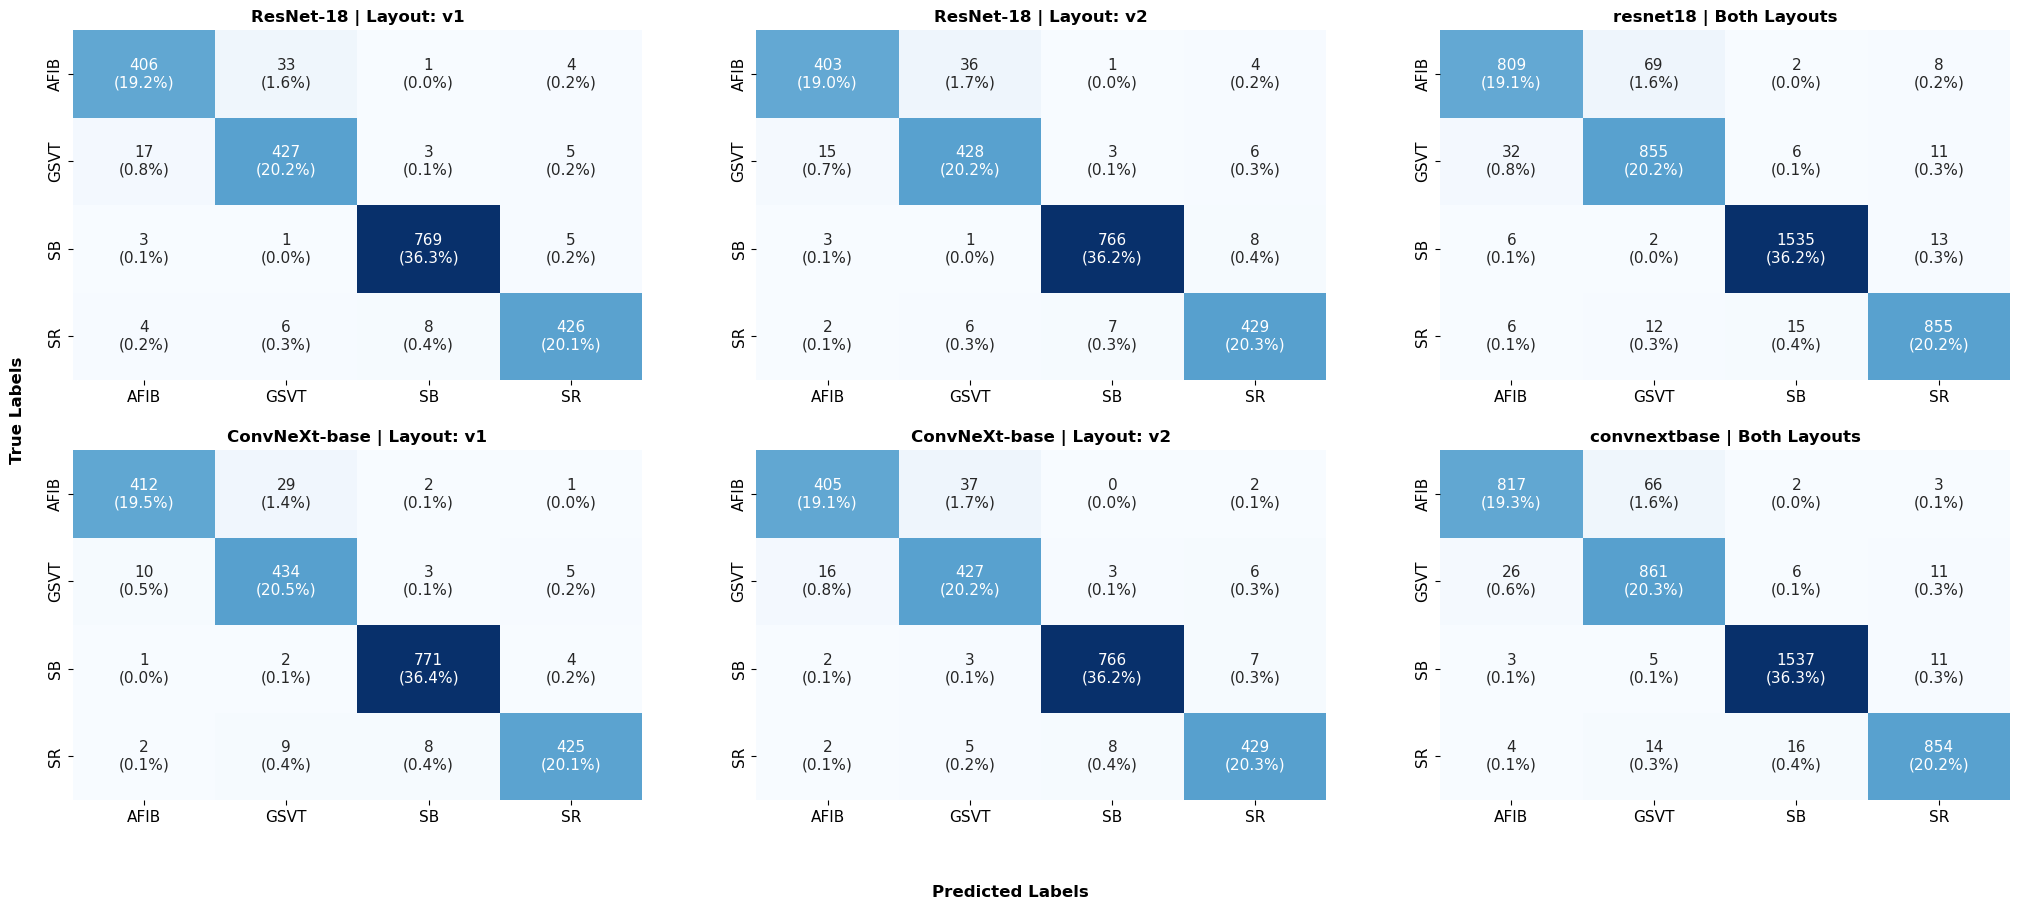

In [147]:
fig, axes = plt.subplots(2,3, figsize=(25,10))

for row_num, arch in enumerate(['resnet18', 'convnextbase']):
    for col_num, pref in enumerate(['v1_std', 'v2_std']):
        filtered_df = consol_outputs_df.query(
            f"model_arch == '{arch}' and prefix == '{pref}'"
        ).copy()

        plot_confusion_matrix(
            filtered_df.true_labels,
            filtered_df.pred_labels,
            l1_rhythm_encoder.classes_,
            display_ax=axes[row_num, col_num]
        )

        axes[row_num, col_num].set_title(f'{arch_name_dict[arch]} | Layout: {pref[:2]}', fontsize=12, fontweight='heavy')
        axes[row_num, col_num].tick_params(labelsize=11)
    
    filtered_df = consol_outputs_df.query(
        f"model_arch == '{arch}'"
    ).copy()

    plot_confusion_matrix(
        filtered_df.true_labels,
        filtered_df.pred_labels,
        l1_rhythm_encoder.classes_,
        display_ax=axes[row_num, 2]
    )

    axes[row_num, 2].set_title(f'{arch} | Both Layouts', fontsize=12, fontweight='heavy')
    axes[row_num, 2].tick_params(labelsize=11)

fig.supylabel("True Labels", x=0.1, fontweight='heavy', fontsize=12)
fig.supxlabel("Predicted Labels", fontweight='heavy', fontsize=12)
plt.show()

##### **5.1.1.b.** Evaluation Metrics by Model and Class

In [37]:
arch_sort = ['resnet18', 'convnextbase']
metrics_sort = [(lab, metric) for lab in ['AFIB', 'GSVT', 'SB', 'SR'] for metric in ['f1', 'recall', 'precision']]

analysis_df.query(
    "dataset_config == 'config2' and metric_name in ['recall', 'precision', 'f1'] and dataset_type == 'test'"
).pivot(
    index=['label_name', 'metric_name'],
    columns=['model_arch'],
    values='results'
).reindex(metrics_sort, columns=arch_sort).round(4)

model_arch              resnet18  convnextbase
label_name metric_name                        
AFIB       f1             0.9294        0.9402
           recall         0.9110        0.9200
           precision      0.9484        0.9612
GSVT       f1             0.9283        0.9308
           recall         0.9458        0.9524
           precision      0.9115        0.9101
SB         f1             0.9859        0.9862
           recall         0.9865        0.9878
           precision      0.9852        0.9846
SR         f1             0.9634        0.9666
           recall         0.9628        0.9617
           precision      0.9639        0.9716